# Exploratory Analysis

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read Data

In [58]:
proj_root = utils.get_proj_root()
config = utils.get_config('config/config.ini')
raw_load_data_path = utils.get_full_path(config['data_paths']['raw_load_data'])
raw_temp_data_path = utils.get_full_path(config['data_paths']['raw_temp_data'])

raw_load_data = pd.read_csv(raw_load_data_path, parse_dates=[0])
raw_temp_data = pd.read_csv(raw_temp_data_path, parse_dates=[0])

print(raw_load_data.head())
print(raw_temp_data.head())

        Date  Hour     Load
0 2005-01-01     1  156.545
1 2005-01-01     2  147.924
2 2005-01-01     3  141.037
3 2005-01-01     4  139.125
4 2005-01-01     5  140.482
        Date  Hour  Station ID  Temperature
0 2005-01-01     1           1           43
1 2005-01-01     2           1           41
2 2005-01-01     3           1           40
3 2005-01-01     4           1           39
4 2005-01-01     5           1           38


## preliminary preprocessing

In [59]:
raw_load_data.columns = ['date', 'hr', 'load']
raw_temp_data.columns = ['date', 'hr', 'station_id', 'temperature']



raw_load_data['datetime'] = raw_load_data.date + pd.to_timedelta(raw_load_data.hr, unit='h')

# Exploration

## Initial view of data

First the data is examined using a time series plot to view the load across time

<Axes: xlabel='datetime', ylabel='Load (kWh)'>

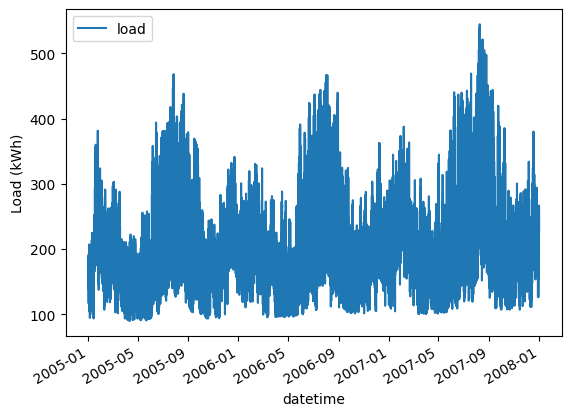

In [60]:

raw_load_data.plot(x='datetime', y='load', ylabel='Load (kWh)')

Already one notices an annual periodic pattern in the data which is sort of expected given what one might expect from electricity usage. 

TO see the patterns more clearly, the data is resampled at different relevant resolutions below:

Text(0, 0.5, 'Load (kWh)')

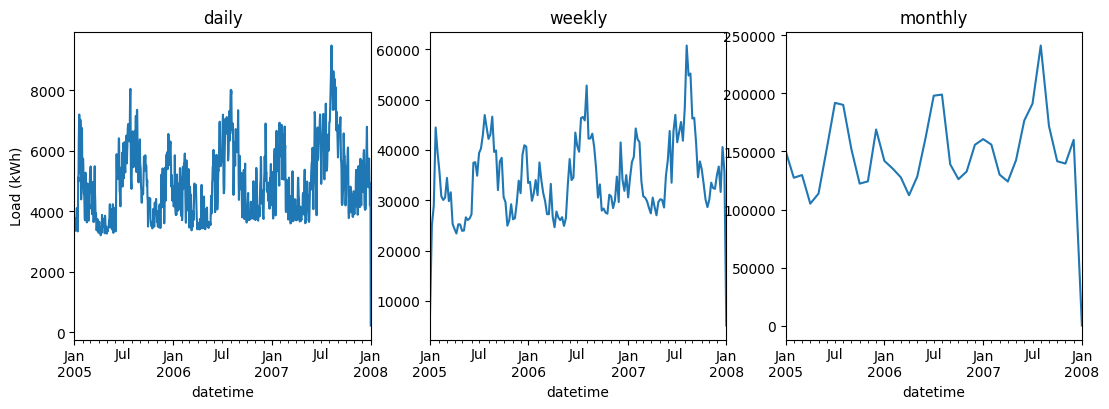

In [61]:
resample_dict = {'daily':'D', 'weekly':'W', 'monthly':'ME'}

fig, axs = plt.subplots(ncols=3, figsize=(13,4))
axs = axs.flatten()
for i, (k, v) in enumerate(resample_dict.items()):

    ax = axs[i]

    raw_load_data.set_index('datetime').resample(v)['load'].sum().plot(ax=ax)
    ax.set_title(k)
axs[0].set_ylabel('Load (kWh)')

The monthly resampling of the data makes clear the annual patterns noticed earlier. In addition, peak load deman is observed annually around July and January which hint at temperature effects. But let's hold on for now.

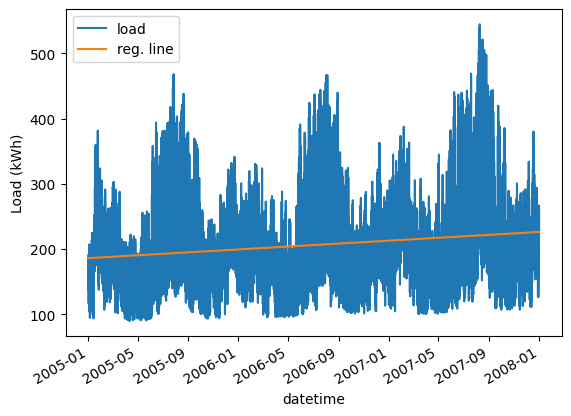

In [62]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()

X = np.arange(len(raw_load_data)).reshape(-1, 1)
y = raw_load_data[['load']]

lin_model.fit(X, y)

y_hat = lin_model.predict(X)

fig, ax = plt.subplots()

raw_load_data.plot(x='datetime', y='load', ax=ax)

ax.plot(raw_load_data.datetime, y_hat, label='reg. line')
ax.set_ylabel('Load (kWh)')

plt.legend()

## knowledge from the data
Based on intuition, we could explore various trajectories which might be relevant to electricity demand. This may include factors based on time of the day, day of the week and month of the year. However, another way might be to leverage the power of unsupervised techniques in discerning patterns from the data with limited assumptions.

In particular, one may consider using the PCA in order to decompose the daily electricity usage patterns. To do this, the data would be transformed such that each 24 hour day is treated as a sample. The PCA might then be able to extract daily usage modes through its first few principal components, hopefully

*Note: daylight saving causes multiple hour 2 on one day and no hour 2 on another day within a year*

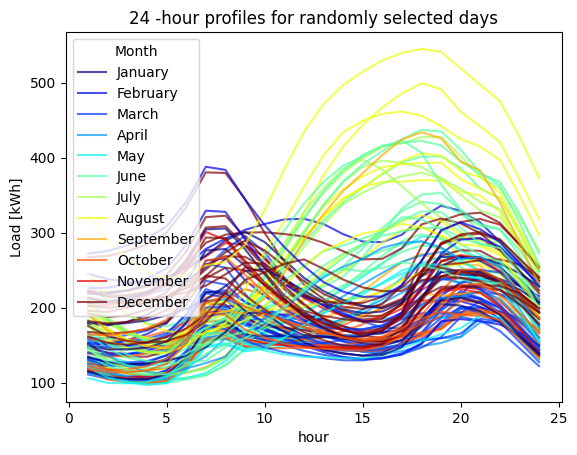

In [63]:

pivoted_load_data = raw_load_data.pivot_table(values='load', index='date', columns='hr')

# plot 24 hour profiles
n=100
sample_idx = np.random.choice(np.arange(pivoted_load_data.shape[0]), size=n, replace=False)
plot_data = pivoted_load_data.iloc[sample_idx, :]

fig, ax = plt.subplots()
import matplotlib
cmap = matplotlib.colormaps['jet'].resampled(12)

labels = []
for i in range(plot_data.shape[0]):
    load_vals = plot_data.iloc[i, :]
    month_name = plot_data.index[i].month_name()
    month = plot_data.index[i].month - 1

    
    if month_name in labels:
        label = None
    else:
        label = month_name
    ax.plot(load_vals, c=cmap(month), alpha=0.7, label=label)
    labels.append(month_name)

ax.set_title('24 -hour profiles for randomly selected days')
ax.set_xlabel('hour')
ax.set_ylabel('Load [kWh]');
ax.legend(title='Month');

# Fix legend order
handles, labels = ax.get_legend_handles_labels()


months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
new_handles = []; new_labels = []
for month in months:
    month_idx = labels.index(month)
    new_handles.append(handles[month_idx])
    new_labels.append(labels[month_idx])

ax.legend(new_handles, new_labels, title='Month');

save_path = proj_root.joinpath('reports/daily_trend.png')
fig.savefig(fname=save_path)

The plot shows randomly sampled 24-hour profiles color-coded by months. This provides a lot of insights into demand pattern by time and month. 

It appears there are two major general patterns, one with 2 peaks, and the other with one peaks. The legend reveals those to correspond to seasons: summer and winter months.

We would leverage the decompositional power of pricipal component analysis to further investigate this while taking all the data into account, rather than a random sample.

In [64]:
pivoted_load_data = raw_load_data.pivot_table(values='load', index='date', columns='hr')
display(pivoted_load_data.head(2))
from sklearn.decomposition import PCA
X = pivoted_load_data.loc[:, 3:].values  # from 3 because some hours are null for hour 2


pca = PCA().fit(X)
ftv = pca.explained_variance_[0:] / np.sum(pca.explained_variance_[0:])

X_pca = pca.transform(X)
X_mean = np.mean(X, axis=0)

hr,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,156.545,147.924,141.037,139.125,140.482,144.726,151.682,160.795,176.263,179.873,...,148.92,147.001,151.095,173.793,190.031,185.218,177.967,169.502,155.938,139.258
2005-01-02,125.346,118.416,116.780,118.143,122.795,129.928,143.200,163.824,189.415,188.124,...,143.25,140.381,144.440,172.000,193.696,193.642,187.023,175.177,155.832,135.549


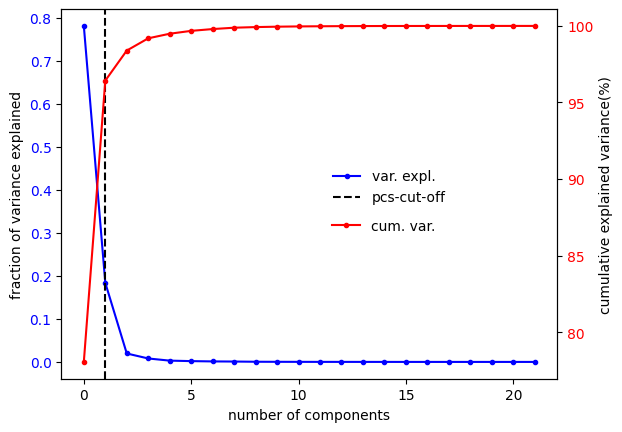

In [65]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
#ax2.plot(np.cumsum(pca.explained_variance_ratio_*100.0), '-.', c='r',  label='cum. var.')
ax2.plot(np.cumsum(ftv*100.0), '.-', c='r',  label='cum. var.')
ax.set_xlabel('number of components')
ax2.set_ylabel('cumulative explained variance(%)');
ax2.ticklabel_format(useOffset=False)


ax.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='r')

ax.plot(np.arange(X.shape[1])[0:], pca.explained_variance_ratio_[0:], '.-', c='b', label='var. expl.')

ax.set_ylabel('fraction of variance explained')

ax.axvline(x=1,  ls='--', c='black', label='pcs-cut-off')

ax.legend(bbox_to_anchor=(0.8,0.6), frameon=False)
ax2.legend(bbox_to_anchor=(0.78,0.465), frameon=False)
ax.grid(False)
ax2.grid(False)

save_path = proj_root.joinpath('reports/pca_plot.png')
fig.savefig(fname=save_path)

The plot above indicates that >95% of the variance in the 24-hour profiles may be captures by projection onto two principal axes. This suggests that there are two major categories of daily electricity usage patterns as suggested earlier. 

But first let's project the 24-hour profiles on the two principal axes and plot the resulting coefficients:

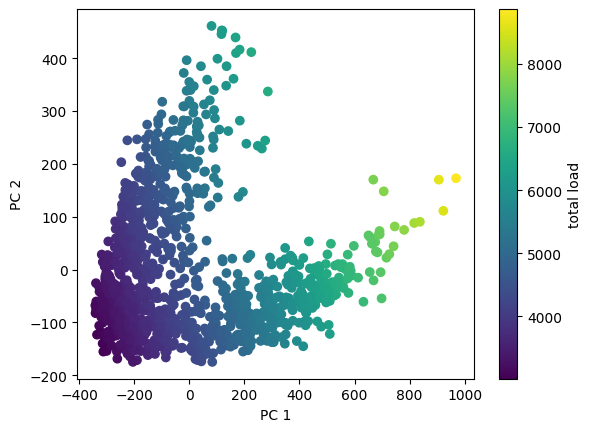

In [70]:
X_pca = PCA(2).fit_transform(X)

total_load = X.sum(axis=1)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=total_load, cmap='viridis')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar(label='total load')

save_path = proj_root.joinpath('reports/pca_coeffs.png')
plt.gcf().savefig(fname=save_path)

The projection reveals the two distinct groups with high magnitude of principal coefficients on the the 1st or 2nd axes. Furthermore the load magnitude overlay shows that a wide range of load magnitude may be seen across the clusters.

We would try to explicitly exrtact the two clusters in order to identify the underlying days, by mapping the cluster number to the dates. To achive that, the unsupervised gaussian mixture model is employed.

/tmp/ipykernel_352/2143833557.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.3, c=cluster_label, cmap=plt.cm.get_cmap('jet', n_components));


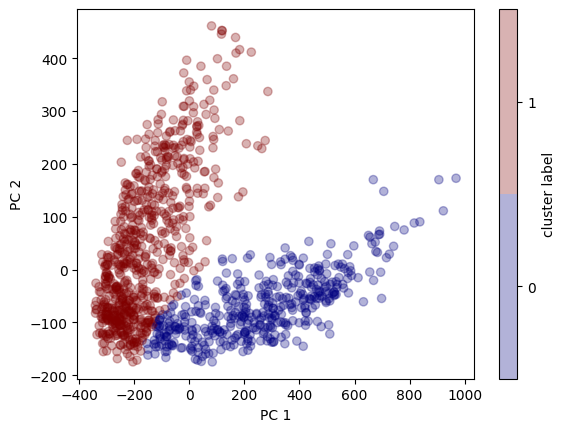

In [69]:
from sklearn.mixture import GaussianMixture as GM

n_components=2
gmm = GM(n_components=n_components, covariance_type='full', random_state=0)

gmm.fit(X_pca)
cluster_label = gmm.predict(X_pca)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.3, c=cluster_label, cmap=plt.cm.get_cmap('jet', n_components));
plt.xlabel('PC 1')
plt.ylabel('PC 2')
cb = plt.colorbar(ticks=range(n_components), label='cluster label')
plt.clim(-0.5, 1.5);

save_path = proj_root.joinpath('reports/pca_cluster.png')
plt.gcf().savefig(fname=save_path)


Now that the cluster is obtained, the points may be mapped back to the dates and gropued accordingly

,date,hr,load,datetime,cluster
0,2005-01-01,1,156.545,2005-01-01 01:00:00,1
1,2005-01-01,2,147.924,2005-01-01 02:00:00,1


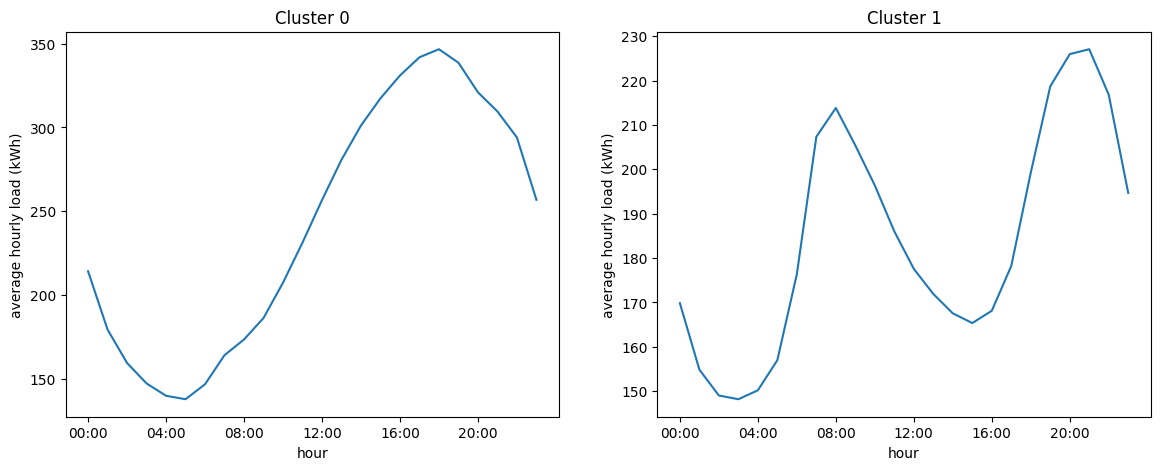

In [71]:
pivoted_load_data['cluster'] = cluster_label

temp_df = raw_load_data.join(pivoted_load_data['cluster'], on='date')
display(temp_df.head(2))
temp_df = temp_df.groupby(['cluster', temp_df.datetime.dt.time]).mean()
# display(temp_df.head())
fig, ax = plt.subplots(1, n_components, figsize=(14, 5))
hourly_ticks = 4 * 60 * 60 * np.arange(6)
# 
for i in range(n_components):
    temp_df.loc[i]['load'].plot(ax=ax[i], xticks=hourly_ticks)
    ax[i].set_title(f'Cluster {i}')
    ax[i].set_ylabel('average hourly load (kWh)')
    ax[i].set_xlabel('hour')

save_path = proj_root.joinpath('reports/pca_cluster_profile.png')
plt.gcf().savefig(fname=save_path)

The above plot represents the mean 24-hour profile for each of the clusters base on the two principal axes.

What we have here are really two major daily profiles representative of what happens across the year. 

Cluster 0, features a daily pattern which includes a declining demand from midnight till very early in the morning following by a gradual increase which peaks in the evening around 17:00 and then declines again towards midnight. 

In clsuter 1, there are two peaks, one around 8am and the other around 8 pm, with intermediate dips around 3:00 and 16:00.

To shed more light on what separates these two days, let's bring in the different months and overlay on the plot of the coefficients along the PCs.

/tmp/ipykernel_352/3035650327.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('jet', 12), alpha=0.4, s=6)


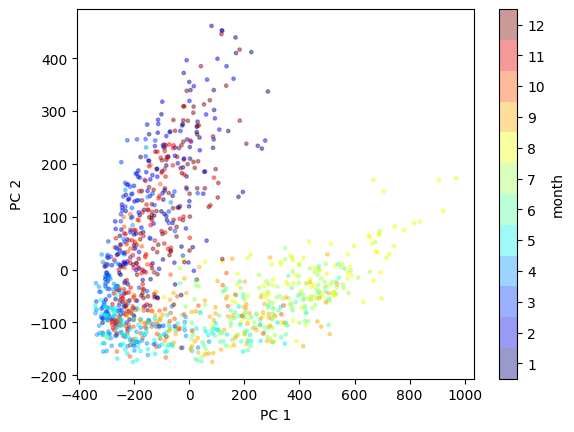

In [73]:
month_of_year = pivoted_load_data.index.month
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=month_of_year,
            cmap=plt.cm.get_cmap('jet', 12), alpha=0.4, s=6)
cb = plt.colorbar(ticks=range(1,12+1), label='month')
# cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.clim(0.5, 12.5);

save_path = proj_root.joinpath('reports/pca_coeffs_month.png')
plt.gcf().savefig(fname=save_path)

mid-year cluster 0:  summer months : 
    - demand: colling during the mid-day period
    - typically no need for morning cooling
January/December are cluster 1: winter months
    - demand: warming in the morning | warming in the evenings

The picture becomes clear now. It appears that cluster 0 are mostly days in the middle of the year, while cluster 1 is dominated by days in the beginning and ending months of the year. This essentially represents the two major seasons of summer and winter months.

So without any initial assumption, we have noticed two major daily patterns and then discovered how those represent summer and winter electricity usage patterns when we overlay the months on the principal co-efficients. While there are some similarities in both seasons, there are notable differences. In the summer months there is a simgle peak which occurs in the evening around 6 pm while here are two peaks in the winter months; one in the morning aroun 8am and the other around 8pm.

To understand this summer winter patterns,, it may be worth considering the nature of electricity use in those tmes. In the summer months, there is often need for cooling in the relatively warmer afternoons, which explains the rise from morning till the early evening where the need for cooling is reduced. In the winter months however, heating would be needed in the mornings and evenings when it is cool and least required in the afternoon where the temperature is typically highest.

This analysis also underscore the strong influence of temperature/weather on energy usage. North Carolina is located well North of the eqautor with significiant temperature swings.  It is possible to imagine that areas closer to the equator where temperatures are more stable year round do not hvae as strong correlation with temperature.

## Demand by Time

Now we would proceed to explicitly explore the correlation of the demand with various time components

### Month

<Axes: xlabel='month', ylabel='load'>

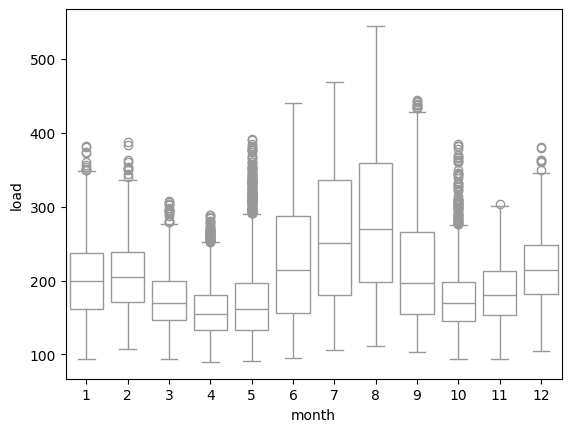

In [40]:
temp_df = (raw_load_data.copy()
           .assign(month = raw_load_data.datetime.dt.month)
           )

sns.boxplot(x='month', y='load', data=temp_df, color='w')

This plot makes clear the distribution of demand for each month showing the median temperature
rises from June to the peak in August followed by a drop in september. The lowest demand
is experienced in April which follows the slight bump in load due to heating deamnd in th winter months
starting from the October dip till February the following year.

This makes the month of the year an important predicitve feature.

### Day of the week

<Axes: xlabel='day_of_wk', ylabel='load'>

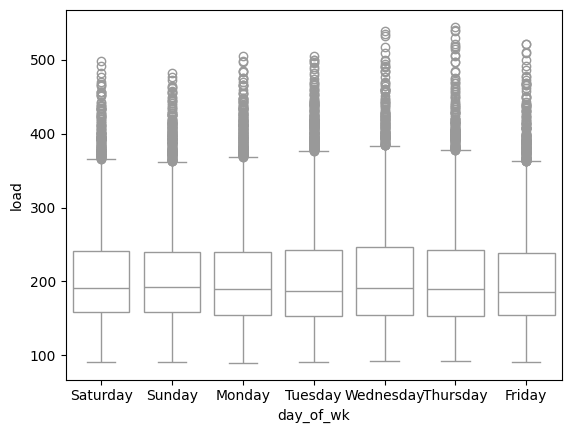

In [41]:
temp_df = (raw_load_data.copy()
           .assign(day_of_wk = raw_load_data.datetime.dt.day_name())
           )


sns.boxplot(x='day_of_wk', y='load', data=temp_df, color='w')


Interestingly, there appears to be no significant differnces in the distribution of loads for 
different days of the week.

### hour of the day

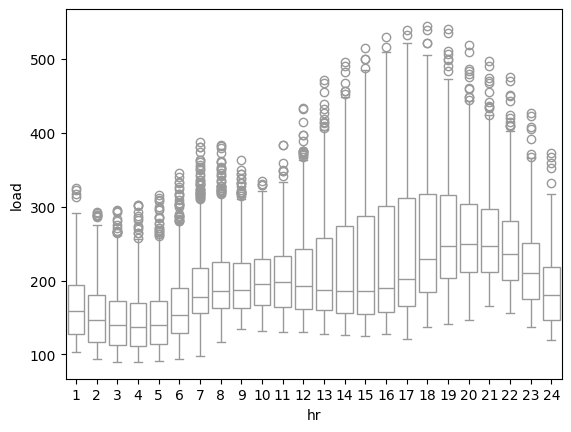

In [42]:
sns.boxplot(x='hr', y='load', data=raw_load_data, color='w');

Expectedly, the distribution shows that the electricity demand peaks in the evening hours around 
17:00. Demand appears to be lowest just before dawn at 5:00. It appears that a descent in demand start
from later in the evening up until early mornings.

This also suggests a significant non-linear variability of load with hour which will be considered in the modelling.


## weekend hours

<Axes: xlabel='hr', ylabel='load'>

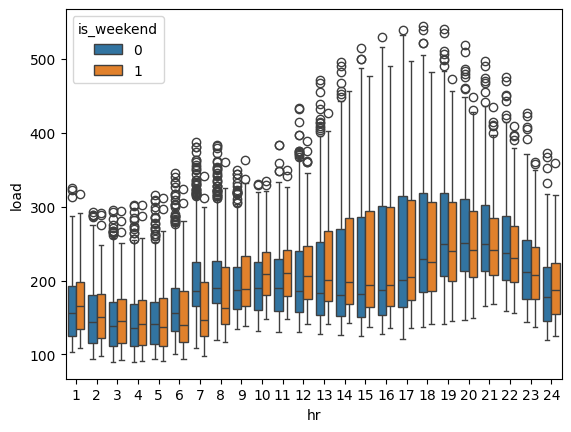

In [43]:
temp_df = (raw_load_data.copy()
           .assign(is_weekend = np.uint8(raw_load_data.datetime.dt.day_of_week > 4))
        #    .query('is_weekend==1')
        )


sns.boxplot(x='hr', y='load', data=temp_df, hue='is_weekend')

Weekends tends to be times when we wake up late and stay home for much longer in the day. From the graph, usage is lower between 6 and 8 am during the weekend which may be attributed to waking relatively later than in weekedays. however, as time passes into the day this reverses with increase usages in the weekend which may be due to families being awake and at home

We have seen that electricity demand is heavily dependent on time including time of day,  month, through waht looks like a combination of the daily activity pattern and climate/weather needs. 

Not much variation in overall demand for different days of the work week. There are some slight variations in usage patterns between weekend and weekdays that follow from intuition. 

## Temperature Data

We would now examine the corresponding temperature data

In [44]:
raw_temp_data.head()

raw_temp_data = raw_temp_data[raw_temp_data.date < '2008']
raw_temp_data['datetime'] = raw_temp_data.date + pd.to_timedelta(raw_temp_data.hr, unit='h')  
display(raw_temp_data.head(3)), 
print(raw_temp_data.shape)

,date,hr,station_id,temperature,datetime
0,2005-01-01,1,1,43,2005-01-01 01:00:00
1,2005-01-01,2,1,41,2005-01-01 02:00:00
2,2005-01-01,3,1,40,2005-01-01 03:00:00


(735840, 5)


In [45]:
n_of_unique_stations = raw_temp_data.station_id.nunique()

n_temp_hours = raw_temp_data.shape[0] / n_of_unique_stations
# print(n_temp_hours)
print(f"There are {n_of_unique_stations} unique stations")

There are 28 unique stations


The dataset consist of hourly temperature readings recorded in 28 different stations

### preprocessing

For modelling purposes, the temperature data is reshaped such that readings from each temperature station is in a seperate columns such that the rows are again hourly intervals, similar to the load

In [46]:
temp_data = (raw_temp_data.copy()
             .query("date < '2008'")
             .assign(dummy_col=np.arange(len(raw_temp_data)) % 2)  # to preserve the repeated hours during pivot
             .pivot_table( values='temperature', index=['date', 'hr','datetime', 'dummy_col'], columns='station_id')
             )


temp_data = (temp_data
             .reset_index()
             .drop(labels=['dummy_col', 'date', 'hr'], axis=1)
             .pipe(lambda d: d.rename(columns=dict([( col, 't'+str(col)) for col in d.columns if isinstance(col, int)])))
             )
temp_data_pivot = temp_data.copy()
display(temp_data_pivot.head(2))

station_id,datetime,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t19,t20,t21,t22,t23,t24,t25,t26,t27,t28
0,2005-01-01 01:00:00,43.0,46.0,40.0,47.0,48.0,46.0,44.0,52.0,45.0,...,39.0,50.0,43.0,45.0,50.0,47.0,41.0,47.0,47.0,45.0
1,2005-01-01 02:00:00,41.0,46.0,38.0,46.0,48.0,45.0,51.0,50.0,42.0,...,41.0,49.0,43.0,46.0,47.0,47.0,45.0,47.0,47.0,45.0


### Exploratory Analysis

Text(0, 0.5, 'Temperature, $^\\circ$F')

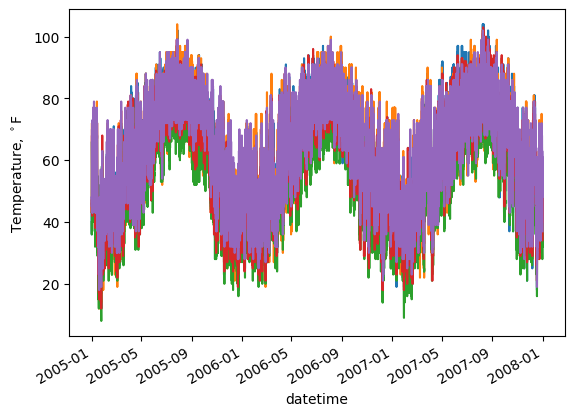

In [47]:
fig, ax = plt.subplots()
temp_data_pivot.set_index('datetime').iloc[:, :5].plot(legend=False, ax=ax)

ax.set_ylabel("Temperature, $^\circ$F")

We see the periodic annual pattern which was already implied by the preiovious analysis

#### Load and Temp

/tmp/ipykernel_31066/1840998436.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('jet', 12), alpha=0.4, s=6)


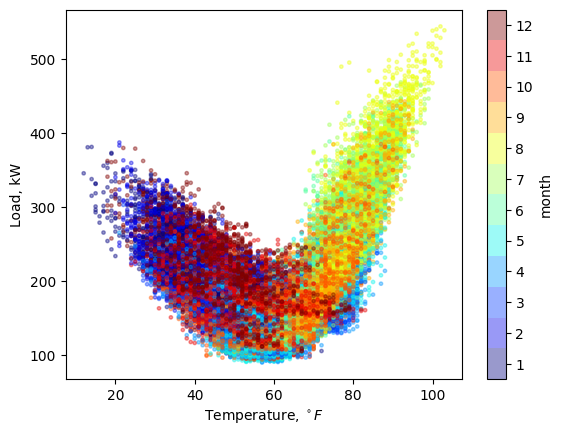

In [48]:
temp_df = (raw_load_data.copy()
           .assign(temp = temp_data_pivot.iloc[:, 4])
           .assign(month = raw_load_data.datetime.dt.month)
           )

# sns.scatterplot(x='temp', y='load', data=temp_df, alpha=0.2, size=0.2, hue='month')

month_of_year = raw_load_data.datetime.dt.month
plt.scatter(x=temp_df.temp, y=raw_load_data.load, c=month_of_year,
            cmap=plt.cm.get_cmap('jet', 12), alpha=0.4, s=6)
cb = plt.colorbar(ticks=range(1,12+1), label='month')
# cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Temperature, $^\circ F$')
plt.ylabel('Load, kW')
plt.clim(0.5, 12.5);

The plot follows some of our preveious finding on the Temperature and load demand. Particularly notable heaere is that cooling demand during high tempretaures in August is largely responsible for the peak loads

#### Temperature Lags

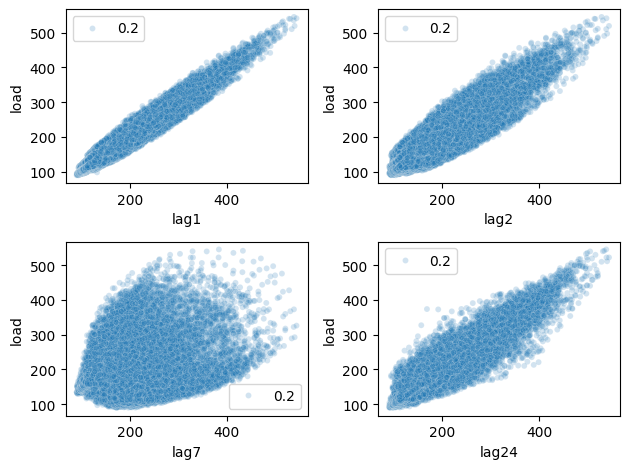

In [49]:
temp_df = (
    raw_load_data.copy()
    .assign(lag1=raw_load_data.load.shift(1))
    .assign(lag2=raw_load_data.load.shift(2))
    .assign(lag7=raw_load_data.load.shift(7))
    .assign(lag24=raw_load_data.load.shift(24))
)
fig, axs = plt.subplots(2, 2)
sns.scatterplot(x="lag1", y="load", data=temp_df, alpha=0.2, size=0.2, ax=axs[0, 0])
sns.scatterplot(x="lag2", y="load", data=temp_df, alpha=0.2, size=0.2, ax=axs[0, 1])
sns.scatterplot(x="lag7", y="load", data=temp_df, alpha=0.2, size=0.2, ax=axs[1, 0])
sns.scatterplot(
    x="lag24", y="load", data=temp_df, alpha=0.2, size=0.2, ax=axs[1, 1]
)
# set_plot_labels(axs, xlabel="temp")
fig.tight_layout()

The plot shows a correlation between the demand and the 1 hr lag. This correlation appears to reduce with
increasing number of hours of the lag but becomes high again after 24 hours, due to same hour trends 
in demand.

Depending on the type of model being used, lag features may be engineered
        in the model building process.